In [1]:
%matplotlib inline

In [2]:
import numpy as np
np.set_printoptions(precision=5, suppress=True, linewidth=150)

import pandas as pd
from matplotlib import pyplot as plt

from sklearn import metrics, preprocessing
from sklearn.externals import joblib

from talib.abstract import *

import math

import random
import timeit
import os

In [3]:
np.random.seed(1337)  # for reproducibility

In [4]:
# Check if folders exist, and if not, create them
def mkdirs(dirs):
    return "Success." if [ os.mkdir(d) for d in dirs if not os.path.exists(d) ] else "Pass."
        
mkdirs(["plt","data"])

'Pass.'

CAGR = 1454.93%
Annual Volatility = 208.29%

Length: 200

HEAD:
      close      open      high       low
0  0.924293  0.924293  0.924293  0.924293
1  0.947505  0.947505  0.947505  0.947505
2  0.965872  0.965872  0.965872  0.965872
3  0.809612  0.809612  0.809612  0.809612
4  1.023489  1.023489  1.023489  1.023489


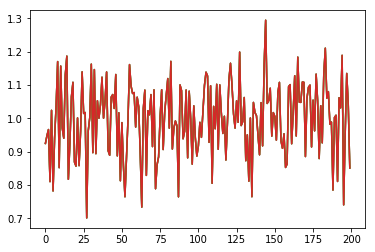

In [5]:
class DataGenerator:
    _days = 365
    _minutes = 365.0 * 24 * 60
    
    def __init__(self, filename="BTRX_BTC-USDT_ohlcv.csv"):
        # Load entire OHLC year of 2017, by minute, into a DataFrame
        self.data = pd.read_csv(filename)
 
        # Calculate the compound annual growth rate (CAGR) which
        # will give us our mean return input (mu)
        minutes = (self.data.index[-1] - self.data.index[0])
        cagr = ((((self.data['close'].iloc[-1]) / self.data['close'].iloc[1])) ** (self._minutes/minutes)) - 1
        self.mu = cagr
        
        #create a series of percentage returns and calculate 
        #the annual volatility of returns
        self.data['returns'] = self.data['close'].pct_change()
        self.annual_volitility = self.data['returns'].std()*math.sqrt(self._minutes)
        
    def generate_data(self, amount=200):
        """By default, generates one year of ohlc minutes"""
        df = pd.DataFrame({
            "close": np.random.normal(
                self.mu / self.data['close'].iloc[-1],
                self.annual_volitility / math.sqrt(self._days),
                amount
            ) + 1
        })
        
        # Duplicate information across ohlc fields
        df[['open']] = df[['close']]
        df[['high', 'low']] = df[['open', 'close']]
        return df


a = DataGenerator()
generated_data = a.generate_data()

print (f"CAGR = {round(a.mu,4)*100}%")
print (f"Annual Volatility = {round(a.annual_volitility,4)*100}%")

print(f"\nLength: {len(generated_data)}\n\nHEAD:\n{generated_data.head()}")

plt.plot(generated_data)
plt.show()

In [6]:
class Backtest(object):
    """
    Backtest class, simple vectorized one. Works with pandas objects.
    """
    
    def __init__(self, price, signal, initial_cash=0, round_shares=True):
        """
        Arguments:
        
        *price*  Series with instrument price.
        *signal* Series with capital to invest (long+,short-) or number of shares. 
        *initial_cash* starting cash. 
        *round_shares* round off number of shares to integers
        """
        
        #TODO: add auto rebalancing
        
        # first thing to do is to clean up the signal, removing nans and duplicate entries or exits
        self.signal = signal.ffill().fillna(0)
        
        # now find dates with a trade
        trade_idx = self.signal.diff().fillna(0) !=0 # days with trades are set to True
        self.trades = self.signal[trade_idx] # selected rows where tradeDir changes value. trades are in Shares
        
        # now create internal data structure 
        self.data = pd.DataFrame(index=price.index , columns = ['price','shares','value','cash','pnl'])
        self.data['price'] = price
        
        self.data['shares'] = self.trades.reindex(self.data.index).ffill().fillna(0)
        self.data['value'] = self.data['shares'] * self.data['price']
       
        delta = self.data['shares'].diff() # shares bought sold
        
        self.data['cash'] = (-delta*self.data['price']).fillna(0).cumsum()+initial_cash
        self.data['pnl'] = self.data['cash']+self.data['value']-initial_cash
      
      
    @property
    def sharpe(self):
        ''' return annualized sharpe ratio of the pnl '''
        pnl = (self.data['pnl'].diff()).shift(-1)[self.data['shares']!=0] # use only days with position.
        return sharpe(pnl)  # need the diff here as sharpe works on daily returns.
        
    @property
    def pnl(self):
        '''easy access to pnl data column '''
        return self.data['pnl']
    
    def plot_trades(self):
        """ 
        visualise trades on the price chart 
            long entry : green triangle up
            short entry : red triangle down
            exit : black circle
        """
        l = ['price']
        
        p = self.data['price']
        p.plot(style='x-')
        
        # ---plot markers
        # this works, but I rather prefer colored markers for each day of position rather than entry-exit signals
#         indices = {'g^': self.trades[self.trades > 0].index , 
#                    'ko':self.trades[self.trades == 0].index, 
#                    'rv':self.trades[self.trades < 0].index}
#        
#         
#         for style, idx in indices.iteritems():
#             if len(idx) > 0:
#                 p[idx].plot(style=style)
        
        # --- plot trades
        #colored line for long positions
        idx = (self.data['shares'] > 0) | (self.data['shares'] > 0).shift(1) 
        if idx.any():
            p[idx].plot(style='go')
            l.append('long')
        
        #colored line for short positions    
        idx = (self.data['shares'] < 0) | (self.data['shares'] < 0).shift(1) 
        if idx.any():
            p[idx].plot(style='ro')
            l.append('short')

        plt.xlim([p.index[0],p.index[-1]]) # show full axis
        
        plt.legend(l,loc='best')
        plt.title('trades')

In [7]:
#This neural network is the the Q-function, run it like this:
#model.predict(state.reshape(1,64), batch_size=1)

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.optimizers import RMSprop, Adam

tsteps = 1
batch_size = 1
num_features = 7

model = Sequential()

model.add(LSTM(64,
               input_shape=(1, num_features),
               return_sequences=True,
               stateful=False))
model.add(Dropout(0.5))

model.add(LSTM(64,
               input_shape=(1, num_features),
               return_sequences=False,
               stateful=False))
model.add(Dropout(0.5))

model.add(Dense(4, kernel_initializer='lecun_uniform'))
model.add(Activation('linear')) #linear output so we can have range of real-valued outputs

adam = Adam()
model.compile(loss='mse', optimizer=adam)

Using TensorFlow backend.
/home/rlarson/.pyenv/versions/3.6.3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [8]:
class MarketEnv:
    x = None
    time_step = 14
    
    def __init__(self,
                 ohlc_file="BTRX_BTC-USDT_ohlcv.csv",
                 train_part=.75,
                 test_part=.25,
                 test=False
                ):
        # Linear gradient
        #prices = pd.DataFrame({
        #    "open": np.arange(200)/100.0,
        #    "high": np.arange(200)/100.0,
        #    "low": np.arange(200)/100.0,
        #    "close": np.arange(200)/100.0,
        #})
        
        # Sine wave
        #prices = pd.DataFrame({
        #   "open": np.sin(np.arange(200)/30.0),
        #   "high": np.sin(np.arange(200)/30.0),
        #   "low": np.sin(np.arange(200)/30.0),
        #   "close": np.sin(np.arange(200)/30.0),
        #})
        
        # Generated data
        #a = DataGenerator()
        #prices = a.generate_data(200)

        # Raw data
        #prices = pd.read_csv(ohlc_file)
        prices = pd.read_csv(ohlc_file).tail(200)
        
        test_start = int(-1 * len(prices)*(test_part))
        train_start = int(-1 * len(prices)*(train_part+test_part))
        
        data = None
        if test:
            data = prices.iloc[train_start:,]
        else:
            data = prices.iloc[train_start:test_start,]
        
        self.signal = pd.Series(index=np.arange(test_start-train_start))
        self.signal.fillna(value=0, inplace=True)

        self.close = data['close'].values
        
        diff = np.diff(self.close)
        diff = np.insert(diff, 0, 0)

        sma15 = SMA(data, timeperiod=15)
        sma60 = SMA(data, timeperiod=60)
        rsi = RSI(data, timeperiod=14)
        atr = ATR(data, timeperiod=14)

        #--- Preprocess data
        self.x = np.column_stack((
            self.close,
            diff,
            sma15,
            self.close - sma15,
            sma15 - sma60,
            rsi,
            atr
        ))
        self.x = np.nan_to_num(self.x)

        self.scaler = self._init_transforms()
        self.x = np.expand_dims(self.scaler.fit_transform(self.x), axis=1)

        self.state = self.x[0:1, 0:1, :]

    def _init_transforms(self):
        scaler = preprocessing.StandardScaler()
        joblib.dump(scaler, 'data/scaler.pkl')
        return scaler
    
    #Take Action
    def take_action(self, action):
        #this should generate a list of trade signals that at evaluation time are fed to the backtester
        #the backtester should get a list of trade signals and a list of price data for the assett

        #make necessary adjustments to state and then return it
        self.time_step += 1

        #if the current iteration is the last state ("terminal state") then set terminal_state to 1
        if self.time_step+1 == self.x.shape[0]:
            self.state = self.x[self.time_step-1:self.time_step, 0:1, :]
            terminal_state = 1
            self.signal.loc[self.time_step] = 0
            return terminal_state

        #move the market data window one step forward
        self.last_state = self.state
        self.state = self.x[self.time_step-1:self.time_step, :]
        #take action
        if action == 1:
            self.signal.loc[self.time_step] = 100
        elif action == 2:
            self.signal.loc[self.time_step] = -100
        else:
            self.signal.loc[self.time_step] = 0
        terminal_state = 0

        return terminal_state

    #Get Reward, the reward is returned at the end of an episode
    def get_reward(self, action, terminal_state, evaluate=False, epoch=0):
        reward = 0

        if evaluate is False:
            bt = Backtest(
                pd.Series(
                    data=[
                        x for x in self.x[self.time_step-2:self.time_step]
                    ],
                    index=self.signal[self.time_step-2:self.time_step].index.values
                ),
                self.signal[self.time_step-2:self.time_step]
            )
            reward = ((bt.data['price'].iloc[-1] -
                       bt.data['price'].iloc[-2]) *
                          bt.data['shares'].iloc[-1])

        elif terminal_state == 1 and evaluate is True:  # wrap it up, we're going home!
            #save a figure of the test set
            bt = Backtest(
                pd.Series(
                    data=[x for x in self.close],
                    index=self.signal.index.values
                ),
                self.signal
            )
            reward = bt.pnl.iloc[-1]
            
            # Update plot
            plt.figure(figsize=(3,4))
            bt.plot_trades()
            plt.axvline(x=400, color='black', linestyle='--')
            plt.text(250, 400, 'training data')
            plt.text(450, 400, 'test data')
            plt.suptitle(str(epoch))
            plt.savefig('plt/'+str(epoch)+'.png', bbox_inches='tight', pad_inches=1, dpi=72)
            plt.close('all')

        return reward


class TestMarketEnv(MarketEnv):
    def __init__(self, *args, **kwargs):
        kwargs["test"] = True
        super().__init__(*args, **kwargs)
    
    def _init_transforms(self):
        scaler = joblib.load('data/scaler.pkl')
        return scaler

In [9]:
def evaluate_q(model, epoch=0):
    #This function is used to evaluate the perofrmance of the system each epoch, without the influence of epsilon and random actions
    #signal = pd.Series(index=np.arange(len(eval_data)))
    env = TestMarketEnv()
    status = 1
    terminal_state = 0
    eval_reward = 0
    while(status == 1):
        #We start in state S
        #Run the Q function on S to get predicted reward values on all the possible actions
        qval = model.predict(env.state, batch_size=1)
        action = (np.argmax(qval))
        #Take action, observe new state S'
        terminal_state = env.take_action(action)
        #Observe reward
        eval_reward = env.get_reward(action, terminal_state, evaluate=True, epoch=epoch)
        
        if terminal_state == 1:
            status = 0

    return eval_reward

In [10]:
epochs = 100
gamma = 0.95 #a high gamma makes a long term reward more valuable
epsilon = 1
batch_size = 10
buffer = 20

In [11]:
start_time = timeit.default_timer()

replay = []
learning_progress = []
#stores tuples of (S, A, R, S')
h = 0

for i in range(epochs):
    if i == epochs-1: #the last epoch, use test data set
        env = TestMarketEnv()
    else:
        env = MarketEnv()

    status = 1
    terminal_state = 0
    
    # While learning is still in progress...
    while(status == 1):
        #We start in state S
        #Run the Q function on S to get predicted reward values on all the possible actions
        qval = model.predict(env.state, batch_size=1)
        if (random.random() < epsilon): #  choose random action
            action = np.random.randint(0,4) #assumes 4 different actions
        else: #choose best action from Q(s,a) values
            action = (np.argmax(qval))
        
        #Take action, observe new state S'
        terminal_state = env.take_action(action)

        #Observe reward
        reward = env.get_reward(action, terminal_state)

        #Experience replay storage
        if (len(replay) < buffer): #if buffer not filled, add to it
            replay.append((env.last_state, action, reward, env.state))
            #print(f"{env.time_step}-- Action: {action}, Reward: {reward[0][action]}")
            #print(env.time_step, reward, terminal_state)
        else: #if buffer full, overwrite old values
            if (h < (buffer-1)):
                h += 1
            else:
                h = 0
            
            replay[h] = (env.last_state, action, reward, env.state)
            
            X_train = []
            y_train = []
            
            #randomly sample our experience replay memory
            for memory in random.sample(replay, batch_size):
                #Get max_Q(S',a)
                old_state, action, reward, new_state = memory
                old_qval = model.predict(old_state, batch_size=1)
                new_qval = model.predict(new_state, batch_size=1)
                max_qval = np.max(new_qval)
                y = np.zeros(old_qval.shape)
                y[:] = old_qval[:]
                if terminal_state == 0:
                    update = (reward + (gamma * max_qval))
                else:
                    update = reward
                #print(f"{env.time_step}-- Action: {action}, Reward: {update[0][action]}, y: {y[0][action]}")
                y[0][action] = update[0][action]
                X_train.append(old_state)
                y_train.append(y.reshape(4,))

            X_train = np.squeeze(np.array(X_train), axis=(1))
            y_train = np.array(y_train)
            model.fit(X_train, y_train, batch_size=batch_size, epochs=1, verbose=0)
            
            state = new_state
        if terminal_state == 1: #if reached terminal state, update epoch status
            status = 0
    eval_reward = evaluate_q(model, i)
    learning_progress.append((eval_reward))
    print(f"Epoch #: {i} Reward: {eval_reward} Epsilon: {epsilon}")
    if epsilon > 0.1: #decrement epsilon over time
        epsilon -= (1.0/epochs)

elapsed = np.round(timeit.default_timer() - start_time, decimals=2)
print("Completed in %f" % (elapsed,))

Epoch #: 0 Reward: 37196.59999899985 Epsilon: 1
Epoch #: 1 Reward: -35880.28406100022 Epsilon: 0.99
Epoch #: 2 Reward: -32681.758351000026 Epsilon: 0.98
Epoch #: 3 Reward: -35803.39999900013 Epsilon: 0.97
Epoch #: 4 Reward: -12603.149690000573 Epsilon: 0.96
Epoch #: 5 Reward: -18529.576150000095 Epsilon: 0.95
Epoch #: 6 Reward: -19810.576003000606 Epsilon: 0.94
Epoch #: 7 Reward: -21327.600001000334 Epsilon: 0.9299999999999999
Epoch #: 8 Reward: -37665.38678100007 Epsilon: 0.9199999999999999
Epoch #: 9 Reward: -35803.39999900013 Epsilon: 0.9099999999999999
Epoch #: 10 Reward: -37196.59999899985 Epsilon: 0.8999999999999999
Epoch #: 11 Reward: -37196.59999899985 Epsilon: 0.8899999999999999
Epoch #: 12 Reward: -35803.39999900013 Epsilon: 0.8799999999999999
Epoch #: 13 Reward: -41814.289582999656 Epsilon: 0.8699999999999999
Epoch #: 14 Reward: -11618.736417000182 Epsilon: 0.8599999999999999
Epoch #: 15 Reward: 3777.1746230006684 Epsilon: 0.8499999999999999
Epoch #: 16 Reward: -30556.690882

In [12]:
#plot results
bt = Backtest(pd.Series(data=[x[0,0] for x in env.x]), env.signal)
bt.data['delta'] = bt.data['shares'].diff().fillna(0)
print(bt.data)

        price  shares       value        cash         pnl  delta
0    0.949396     0.0    0.000000    0.000000    0.000000    0.0
1    0.949566     0.0    0.000000    0.000000    0.000000    0.0
2    0.949566     0.0    0.000000    0.000000    0.000000    0.0
3    0.949396     0.0    0.000000    0.000000    0.000000    0.0
4    0.463292     0.0    0.000000    0.000000    0.000000    0.0
5    0.457653     0.0    0.000000    0.000000    0.000000    0.0
6    0.453141     0.0    0.000000    0.000000    0.000000    0.0
7    0.463292     0.0    0.000000    0.000000    0.000000    0.0
8    0.441863     0.0    0.000000    0.000000    0.000000    0.0
9    0.100970     0.0    0.000000    0.000000    0.000000    0.0
10   0.441863     0.0    0.000000    0.000000    0.000000    0.0
11  -1.159687     0.0   -0.000000    0.000000    0.000000    0.0
12  -1.148408     0.0   -0.000000    0.000000    0.000000    0.0
13  -1.486764     0.0   -0.000000    0.000000    0.000000    0.0
14  -1.430371     0.0   -

In [13]:
unique, counts = np.unique(filter(lambda v: v==v, env.signal.values), return_counts=True)
print(np.asarray((unique, counts)).T)

[[<filter object at 0x7f1deffa3fd0> 1]]


In [14]:
plt.figure()
bt.plot_trades()
plt.suptitle('epoch' + str(i))
plt.savefig('plt/final_trades'+'.png', bbox_inches='tight', pad_inches=1, dpi=72) #assumes there is a ./plt dir
plt.close('all')

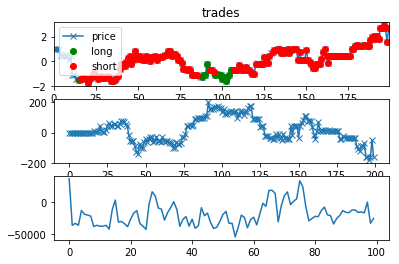

In [15]:
plt.figure()
plt.subplot(3,1,1)
bt.plot_trades()
plt.subplot(3,1,2)
bt.pnl.plot(style='x-')
plt.subplot(3,1,3)
plt.plot(learning_progress)

plt.savefig('plt/summary'+'.png', bbox_inches='tight', pad_inches=1, dpi=72)
plt.show()